In [5]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sl_ai.utils import clean_listdir

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
# dataset = Path('gestures_dataset_new.csv')
# DATASET_CSV = Path('../gestures_dataset.csv')
DATASET_ROOT = Path('../ai_data/vgt-all')

# UPLOADED_DATASET_CSV = Path('../uploaded_gestures_dataset.csv')
UPLOADED_GESTURES_ROOT = Path('../ai_data/vgt-uploaded')

In [7]:
def handedness_data_from_directory_names(dataset_location: Path):
    handedness_data = {}
    for gesture_folder in clean_listdir(dataset_location):
        *gestures_name_parts, handedness_string = gesture_folder.split("_")
        gesture_name = "_".join(gestures_name_parts)
        handedness_data[gesture_name] = (
            handedness_string[0] == "1",
            handedness_string[1] == "1",
        )
    return handedness_data

In [8]:
%load_ext autoreload
%autoreload 2
from sl_ai.dataset import GestureDataset

gesture_dataset: GestureDataset = GestureDataset()
gesture_dataset.scan_videos(dataset_location=DATASET_ROOT, handedness_data=handedness_data_from_directory_names(DATASET_ROOT))
# gesture_dataset.analyze_videos(csv_out_path=DATASET_CSV, overwrite=True)
gesture_dataset.load_gestures_from_csv()


for user_folder in clean_listdir(UPLOADED_GESTURES_ROOT):
    for gesture_folder in clean_listdir(UPLOADED_GESTURES_ROOT / user_folder):
        csv_files = list(
            filter(
                lambda file: file.endswith(".csv"),
                clean_listdir(
                    UPLOADED_GESTURES_ROOT / user_folder / gesture_folder
                ),
            )
        )
        if not csv_files:
            print(
                "Warning: Found a uploaded gesture folder without a dataset.csv file."
            )
            continue
        dataset_file = csv_files[0]
        print(
            f"Loading dataset from {UPLOADED_GESTURES_ROOT / user_folder / gesture_folder / dataset_file}"
        )
        *gestures_words, handedness_string = gesture_folder.split("_")
        gesture_name = "_".join(gestures_words)
        uploaded_gesture_dataset = GestureDataset(single_gesture=True)
        uploaded_gesture_dataset.scan_videos(
            dataset_location=UPLOADED_GESTURES_ROOT
            / user_folder
            / gesture_folder,
            handedness_data={
                gesture_name: (
                    handedness_string[0] == "1",
                    handedness_string[1] == "1",
                )
            },
        )
        uploaded_gesture_dataset.load_from_csv(
            csv_path=UPLOADED_GESTURES_ROOT
            / user_folder
            / gesture_folder
            / dataset_file
        )
        gesture_dataset.append_dataset(uploaded_gesture_dataset)

gesture_dataset.summary()
# df = pd.DataFrame(gesture_dataset.X_dataset)
# print(df.info)
# print(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New lookup dict:
{0: 'Arbeider',
 1: 'België',
 2: 'Bij',
 3: 'Bowlen',
 4: 'Buffel',
 5: 'Computer',
 6: 'Duidelijk',
 7: 'Eekhoorn',
 8: 'Egel',
 9: 'Fietsen',
 10: 'Gebaar',
 11: 'Geit',
 12: 'Giraf',
 13: 'Hallo',
 14: 'Hond',
 15: 'Kalf',
 16: 'Kameel',
 17: 'Kat',
 18: 'Muis',
 19: 'Mus',
 20: 'Salamander',
 21: 'Spin',
 22: 'Tennis',
 23: 'Tijger',
 24: 'Uil',
 25: 'Varken',
 26: 'Verenigde Staten',
 27: 'Vlieg'}
Dataset contain 28 gestures.


In [9]:
%load_ext autoreload
%autoreload 2
from sl_ai.gesture_classifier import GestureClassifier
classifier: GestureClassifier = GestureClassifier(gesture_dataset=gesture_dataset)
classifier.train(train_size=.6, type='lstm')
classifier.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset contain 28 gestures.
Training on shape: (12, 100)
Dateset shape: (338, 12, 100)
Epoch 1/1000
338/338 [==============================] - 4s 7ms/step - loss: 3.2700 - sparse_categorical_accuracy: 0.1124 - val_loss: 2.7150 - val_sparse_categorical_accuracy: 0.2743
Epoch 2/1000
338/338 [==============================] - 2s 5ms/step - loss: 2.4909 - sparse_categorical_accuracy: 0.2840 - val_loss: 2.0846 - val_sparse_categorical_accuracy: 0.4071
Epoch 3/1000
338/338 [==============================] - 2s 5ms/step - loss: 1.9611 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.6152 - val_sparse_categorical_accuracy: 0.5929
Epoch 4/1000
338/338 [==============================] - 2s 5ms/step - loss: 1.7127 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.3829 - val_sparse_categorical_accuracy: 0.5752
Epoch 5/1000
338/338 [==============================] - 2s 5ms/step - loss: 1.4802 - sparse_cate

4/4 [==============================] - 1s 3ms/step


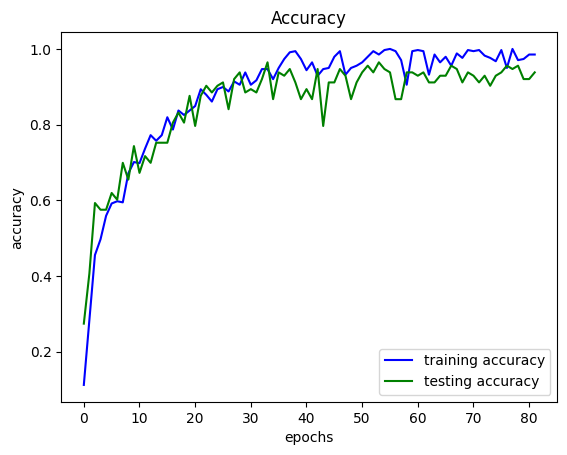

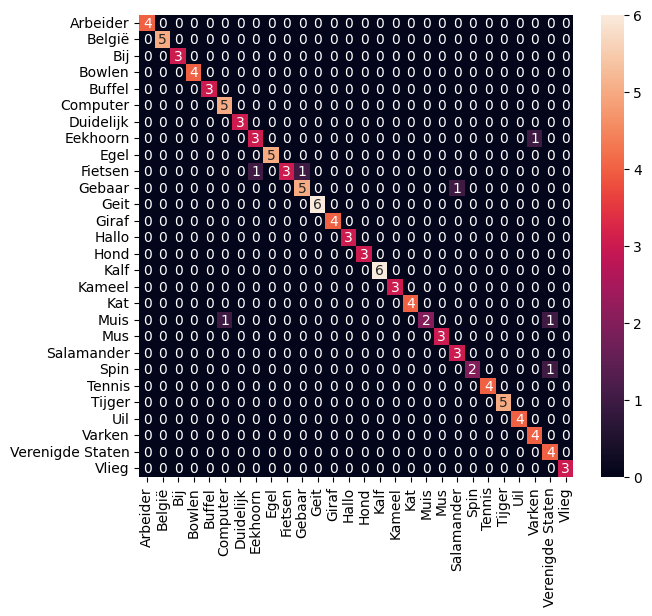

In [10]:
classifier.visualize_accuracy()
classifier.confusion_matrix()

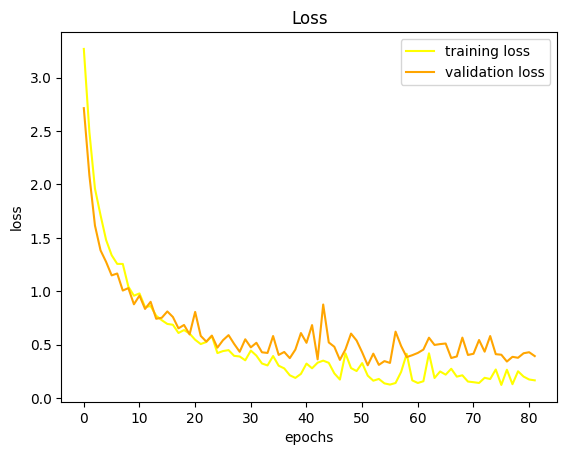

In [11]:
classifier.visualize_loss()

In [12]:
classifier.save_model("../model.h5")